In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, month_plot
from arch.unitroot import ADF, KPSS
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.holtwinters import Holt
from scipy.stats.mstats import winsorize
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

import evds as ev

In [2]:
with open("/Users/neseuygun/Desktop/evds_api_key.txt") as file:
    api = file.read()

evds = ev.evdsAPI(api)
data = evds.get_data(["TP.SANAYREV4.Y1"], startdate="01-01-2005", enddate="01-01-2024")
data

,Tarih,TP_SANAYREV4_Y1
0,2005-1,49.916096
1,2005-2,51.258907
2,2005-3,58.721277
3,2005-4,56.634538
4,2005-5,59.082966
...,...,...
221,2023-6,137.891848
222,2023-7,145.483816
223,2023-8,149.309724
224,2023-9,151.314033


In [3]:
data.rename(columns={"Tarih":"Date", "TP_SANAYREV4_Y1":"Industry Production Index"}, inplace=True)
data["Date"] = pd.date_range("01-01-2005", periods=len(data), freq="M")
data.set_index("Date", inplace=True)
data

,Industry Production Index
Date,
2005-01-31,49.916096
2005-02-28,51.258907
2005-03-31,58.721277
2005-04-30,56.634538
2005-05-31,59.082966
...,...
2023-06-30,137.891848
2023-07-31,145.483816
2023-08-31,149.309724


<function matplotlib.pyplot.show(close=None, block=None)>

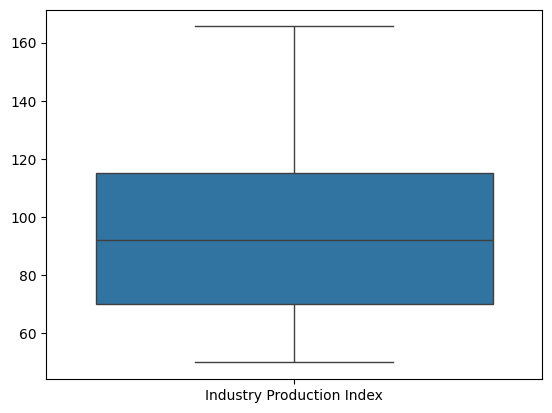

In [4]:
#check if the series has outliers 
sns.boxplot(data)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

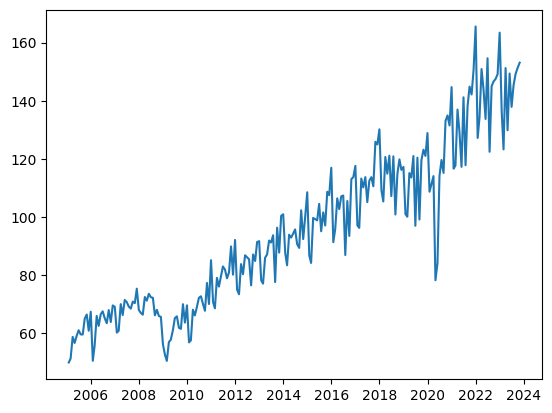

In [5]:
#quick check trend of the series
plt.plot(data)
plt.show

Figure(640x480)
Figure(640x480)


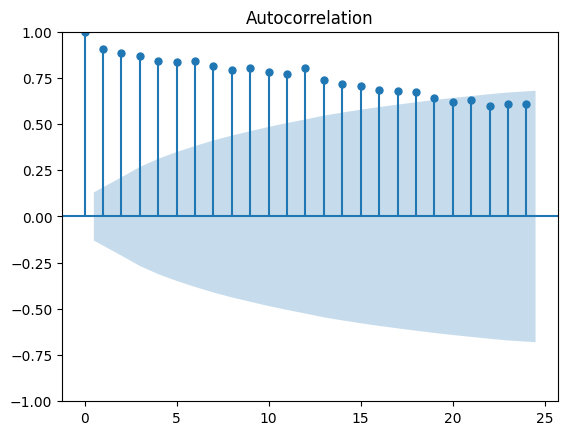

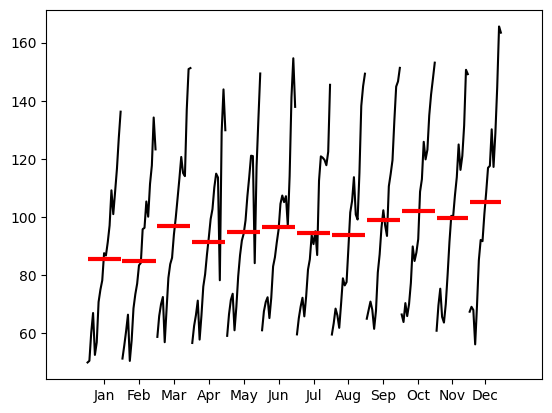

In [6]:
# lets check seaonality situation of the series
print(plot_acf(data))
print(month_plot(data))

In [7]:
# split data
train = data.iloc[:-24]
test = data.iloc[-24:]

In [8]:
#cheking whether the series is stationary with ADF nd KPSS statistical tests.
adf = ADF(train)
kpss = KPSS(train)

print(adf)
print(kpss)

   Augmented Dickey-Fuller Results   
Test Statistic                  0.325
P-value                         0.978
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  2.074
P-value                         0.000
Lags                                9
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


/Users/neseuygun/miniconda3/lib/python3.11/site-packages/arch/unitroot/unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]


according tp stastical test result the series is not stationary

In [9]:
# take difference to make stationary the series
datadiff = train.diff().dropna()

adf = ADF(datadiff)
kpss = KPSS(datadiff)

print(adf)
print(kpss)

   Augmented Dickey-Fuller Results   
Test Statistic                 -4.520
P-value                         0.000
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  0.075
P-value                         0.723
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


/Users/neseuygun/miniconda3/lib/python3.11/site-packages/arch/unitroot/unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]


In [10]:
# model without seasonality
model = auto_arima(train, trace=True, seasonal=False)
model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1433.565, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1501.742, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1461.651, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1432.552, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1500.161, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1430.603, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1431.570, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1431.829, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1431.303, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1451.730, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1436.890, Time=0.02 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.457 seconds


ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)

In [11]:
model.aic()

1430.6032190920066

In [12]:
# model with seasonality
results = {}
for i in range(2,13):
    smodel = auto_arima(train, trace=False, seasonal=True, m=i)
    key = "m" + str(i)
    results[key] = smodel.aic()

#Sort the dictionary items based on AIC values
sorted_results = sorted(results.items(), key=lambda x:x[1])

# Get the two items with the lowest AIC values
min_two_results = sorted_results[:2]

In [13]:
min_two_results

[('m12', 1354.339676237856), ('m4', 1372.6573401378373)]

In [14]:
min(results.values())

1354.339676237856

In [15]:
# lets set up arima model for these both two min values
smodel1 = auto_arima(train, trace=False, seasonal=True, m=4)
smodel2 = auto_arima(train, trace=False, seasonal=True, m=12)

In [16]:
print(smodel1.summary())
print(smodel2.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  202
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 4)   Log Likelihood                -679.329
Date:                                Sat, 30 Dec 2023   AIC                           1372.657
Time:                                        22:01:48   BIC                           1395.780
Sample:                                    01-31-2005   HQIC                          1382.014
                                         - 10-31-2021                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1444      0.440      2.600      0.009       0.282       2.007
ma.

as we chekc the both models statistical results, we can see smodel1 p_values are meaningfull sp we will continue with this model

In [17]:
# now check if the error has white noise or not
error1 = model.resid()
error2 = smodel1.resid()

q1 = acorr_ljungbox(error1)
q2 = acorr_ljungbox(error2)
print(q1)
print()
print(q2)

     lb_stat  lb_pvalue
1   0.013439   0.907710
2   1.128602   0.568758
3   1.198368   0.753396
4   2.650640   0.617879
5   2.662401   0.751863
6   4.373225   0.626306
7   4.579784   0.711090
8   6.183742   0.626658
9   6.566710   0.682130
10  7.258735   0.700814

     lb_stat  lb_pvalue
1   0.042024   0.837573
2   1.559585   0.458501
3   1.765744   0.622418
4   2.718403   0.605998
5   2.897249   0.715823
6   2.966261   0.813069
7   3.650789   0.819006
8   5.601678   0.691751
9   6.471510   0.691956
10  7.391411   0.688048


Both models are in white noise process

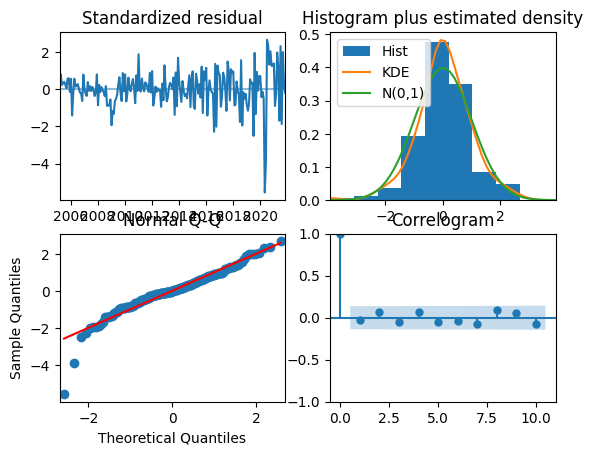

In [18]:
# lets get some information about residuals
smodel1.plot_diagnostics()
plt.show()

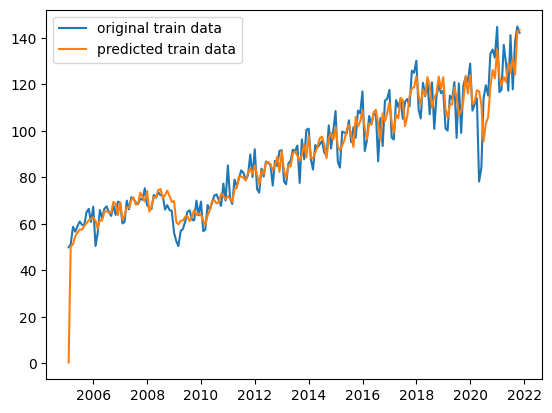

In [19]:
# prediction comparision for train data
predicttrain = smodel1.fittedvalues()

plt.plot(train, label="original train data")
plt.plot(predicttrain, label="predicted train data")
plt.legend()
plt.show()

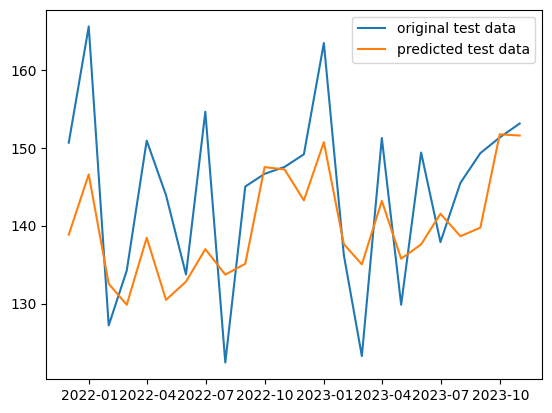

In [20]:
# prediction comparision for test data
prediction = smodel1.predict(24)

plt.plot(test, label="original test data")
plt.plot(prediction, label="predicted test data")
plt.legend()
plt.show()

In [21]:
#prediction error
def error(y_true, y_pred):
    print("RMSE: {}".format(np.sqrt(mean_squared_error(y_true, y_pred))))
    print("R2: {}".format(r2_score(y_true, y_pred)))

error(train, predicttrain)
error(test, prediction)

RMSE: 7.815906292491291
R2: 0.8871417468115258
RMSE: 9.469048574237304
R2: 0.2867738141845174


# These results show us our model is overfitting

In [22]:
# Now get new result with time series cross validation
tscv = TimeSeriesSplit(n_splits=5)

rmse_point = []
r2_point = []

for train_index, test_index in tscv.split(data):
    train, test = data.iloc[train_index], data.iloc[test_index]
    model = auto_arima(train, trace=False, seasonal=True, m=4)
    prediction = model.predict(len(test))
    rmse = np.sqrt(mean_squared_error(test, prediction))
    rmse_point.append(rmse)
    r2 = r2_score(test, prediction)
    r2_point.append(r2)

print(rmse_point)
print(r2_point)

[13.427172329511578, 8.651602641536176, 8.19770553630602, 14.603450552980187, 28.494562967911005]
[-1.8558011076912875, -0.5338803341478977, 0.14890821093764994, -0.5812434955787082, -4.195037511431378]


In [23]:
np.mean(rmse_point)

14.674898805648994

In [24]:
list(zip(rmse_point,r2_point))

[(13.427172329511578, -1.8558011076912875),
 (8.651602641536176, -0.5338803341478977),
 (8.19770553630602, 0.14890821093764994),
 (14.603450552980187, -0.5812434955787082),
 (28.494562967911005, -4.195037511431378)]

In [25]:
data

,Industry Production Index
Date,
2005-01-31,49.916096
2005-02-28,51.258907
2005-03-31,58.721277
2005-04-30,56.634538
2005-05-31,59.082966
...,...
2023-06-30,137.891848
2023-07-31,145.483816
2023-08-31,149.309724


In [31]:
k = np.array(data["Industry Production Index"]).reshape(-1,1)